# Testing Plasticity Decay

Questions:
- Can I reproduce this phenomena?
- What impacts the speed of the decay?
    - Potential parameters: learning rate, batch size, number of updates, frequency of permutation, difference of new permutation
- What is causing the decay?
    - How do the weights in each layer change over time?
- Does the speed to adapt to a given level of performance per permutation change over the course of training?

In [3]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
from tqdm import tqdm

%matplotlib inline

In [4]:
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    lambda x: x.view(-1)
])

# Download and load MNIST dataset
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=img_transform)

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# Function for creating a new transform that permutes `n_permute` pixels
def create_new_permutation(n_input, n_permute):
    old_indices = torch.randperm(n_input)[:n_permute]
    new_indices = old_indices[torch.randperm(n_permute)]
    def new_transform(x):
        if len(x.shape) > 1:
            return torch.stack([new_transform(sample) for sample in x], dim=0)
        x[new_indices] = copy.deepcopy(x)[old_indices]
        return x
    return new_transform

In [6]:
# Create a simple feed-forward network for MNIST classification
class DenseModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.n_hidden = 128
        self.layers = nn.Sequential(
            nn.Linear(n_input, self.n_hidden),
            nn.ReLU(),
            nn.Linear(self.n_hidden, self.n_hidden),
            nn.ReLU(),
            nn.Linear(self.n_hidden, n_output))

    def forward(self, x):
        return self.layers(x)

    def probs(self, x):
        return torch.softmax(self(x), dim=1)

In [23]:
data_dim = 28 * 28
n_classes = 10

batch_size = 16
training_samples = int(5e7)
n_permute = 600
change_permute_freq = 400000 // batch_size * batch_size

lr = 0.001

model = DenseModel(data_dim, n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Create a simple dataloader for the MNIST dataset that loops on completion
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0)

In [24]:
n_samples = len(dataset)
criterion = nn.CrossEntropyLoss()
permute_transform = create_new_permutation(data_dim, n_permute)

acc_hist, loss_hist = [], []
data_iter = iter(dataloader)
for step_idx in tqdm(range(1, training_samples // batch_size + 1)):
    try:
        x, y = next(data_iter)
    except StopIteration:
        data_iter = iter(dataloader)
        x, y = next(data_iter)
    x = permute_transform(x)
    
    y = torch.tensor(y)
    logits = model(x)
    pred_y = torch.argmax(logits, dim=1)
    loss = criterion(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_hist.append(loss.item())
    acc_hist.append(torch.sum(pred_y == y).item() / len(y))

    if step_idx * batch_size % change_permute_freq == 0:
        permute_transform = create_new_permutation(data_dim, n_permute)

  0%|          | 0/3125000 [00:00<?, ?it/s]<ipython-input-24-d2c7622e82fb>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
 89%|████████▉ | 2792964/3125000 [3:52:11<27:36, 200.49it/s]  


KeyboardInterrupt: 

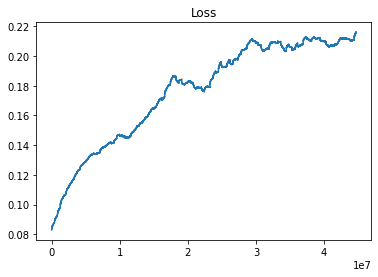

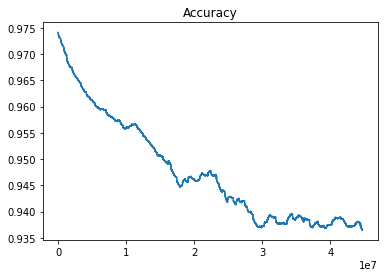

In [29]:
# Plot the moving average of loss and accuracy
# Source: https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

avg_len = 100000

plt.title('Loss')
ys = moving_average(loss_hist, avg_len)
xs = np.arange(len(ys)) / len(ys) * len(loss_hist) * batch_size
plt.plot(xs, ys)
plt.show()

plt.title('Accuracy')
ys = moving_average(acc_hist, avg_len)
xs = np.arange(len(ys)) / len(ys) * len(acc_hist) * batch_size
plt.plot(xs, ys)
plt.show()